<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Naive Bayes Language Detection Lab
---

In this lab, we’ll use Naive Bayes (and other classifiers) to auto-detect the language of a given tweet. We’ll then assess the performance of our classifier.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [117]:
tweets_df = pd.read_csv("./datasets/tweets_language.csv")
tweets_df.drop([tweets_df.columns[0]], axis=1, inplace=True)
# By default, everything read in is a string!
tweets_df.index = tweets_df.index.astype(int)

In [118]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9431 entries, 0 to 9430
Data columns (total 2 columns):
LANG    9409 non-null object
TEXT    9409 non-null object
dtypes: object(2)
memory usage: 147.4+ KB


In [119]:
# Note: Some of the rows above are null, so we can't use them for training.
tweets_df = tweets_df.dropna()

In [120]:
tweets_df.head()

,LANG,TEXT
0,en,The #Yolo bailout: Greece's ex-finance chief h...
1,en,Another mental Saturday night. It will be near...
2,en,Sometimes you take bedtime selfies w yer hat s...
3,en,Currently just changed my entire outfit includ...
4,en,I just like listening to @SpotifyAU's top 100 ...


In [122]:
tweets_df[tweets_df['LANG']=='uk'].head()

,LANG,TEXT
8336,uk,Трип #Pskov #russia #memories #chill #instasiz...
8337,uk,Панель №6 | Украина.ру http://t.co/sPGryDw1KP ...
8338,uk,"Скоро повторим, жди #friends #bestfriends #be..."
8339,uk,•ѕтєυρρѕ #US ℓιкє тσ тαкє ¢яє∂ιт fσя єνєяутнιи...
8340,uk,RT @hugoturner1969: Via @justfightX \nАртём Гр...


### 1) Data exploration.

#### 1.A) Explore a list of tweet words that occur more than 50 times.
Plot a histogram that might be helpful.

(array([42.,  4.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 174., 1011., 1848., 2685., 3522., 4359., 5196., 6033., 6870.,
        7707., 8544.]),
 <a list of 10 Patch objects>)

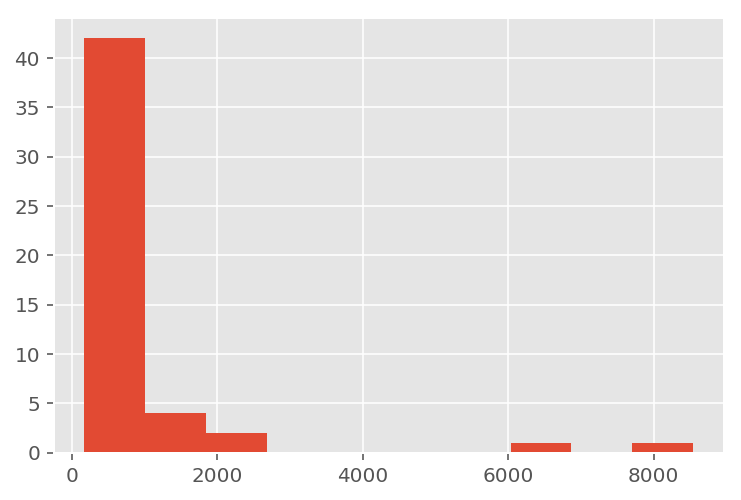

In [16]:
# Let's use the CountVectorizer to count words for us.
cvec = CountVectorizer(strip_accents='unicode', ngram_range=(1, 1))
X_all = cvec.fit_transform(tweets_df['TEXT'])

# Complete the code.
X_top_50 = pd.DataFrame(X_all.toarray(), columns=cvec.get_feature_names()).sum().sort_values(ascending=False).head(50)
plt.hist(X_top_50)

#### 1.B) Investigate the `counts` histogram.

In [18]:
X_counts = pd.DataFrame(X_all.toarray(), columns=cvec.get_feature_names()).sum().sort_values(ascending=False)

(array([3.294e+04, 6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 8.5530e+02, 1.7096e+03, 2.5639e+03, 3.4182e+03,
        4.2725e+03, 5.1268e+03, 5.9811e+03, 6.8354e+03, 7.6897e+03,
        8.5440e+03]),
 <a list of 10 Patch objects>)

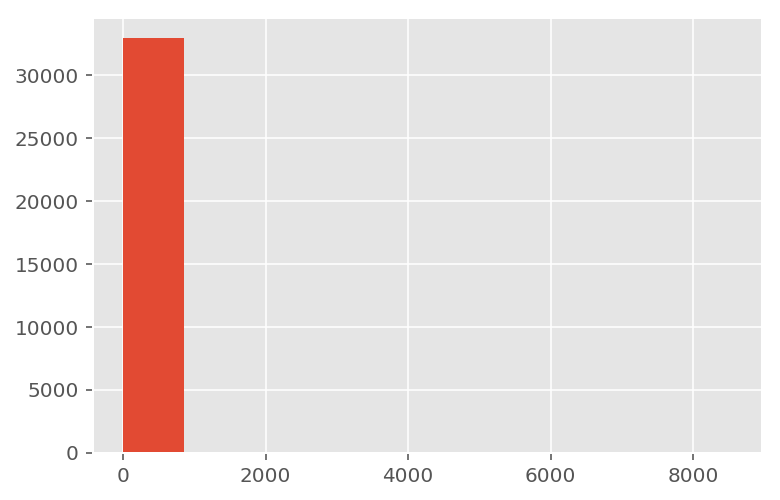

In [25]:
plt.hist(X_counts)

#### 1.C) Try it again with stop word removal.

In [30]:
# Let's use the CountVectorizer to count words for us.
cvt = CountVectorizer(strip_accents='unicode', stop_words='english')
X_all = cvt.fit_transform(tweets_df['TEXT'])

# Complete the code.
X_top_50 = pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names()).sum().sort_values(ascending=False).head(50)
X_counts = pd.DataFrame(X_all.toarray(), columns=cvt.get_feature_names()).sum().sort_values(ascending=False)

In [38]:
X_top_50

http            6093
https           2658
rt              2222
love            1758
dog             1219
family          1082
france          1032
da               889
peace            811
yolo             742
la               723
earth            702
planet           589
math             473
en               425
hund             333
que              332
vive             307
silver           304
paris            290
amp              275
happy            260
photo            249
le               242
cute             230
naturevalley     193
lang             192
usa              182
est              182
life             179
russia           178
el               178
summer           174
les              170
dollar           166
ich              166
uk               158
coins            152
junksilver       151
gt               145
pet              144
di               143
et               142
ukraine          139
germany          139
follow           139
al               138
art          

(array([3.2717e+04, 8.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 6.1020e+02, 1.2194e+03, 1.8286e+03, 2.4378e+03,
        3.0470e+03, 3.6562e+03, 4.2654e+03, 4.8746e+03, 5.4838e+03,
        6.0930e+03]),
 <a list of 10 Patch objects>)

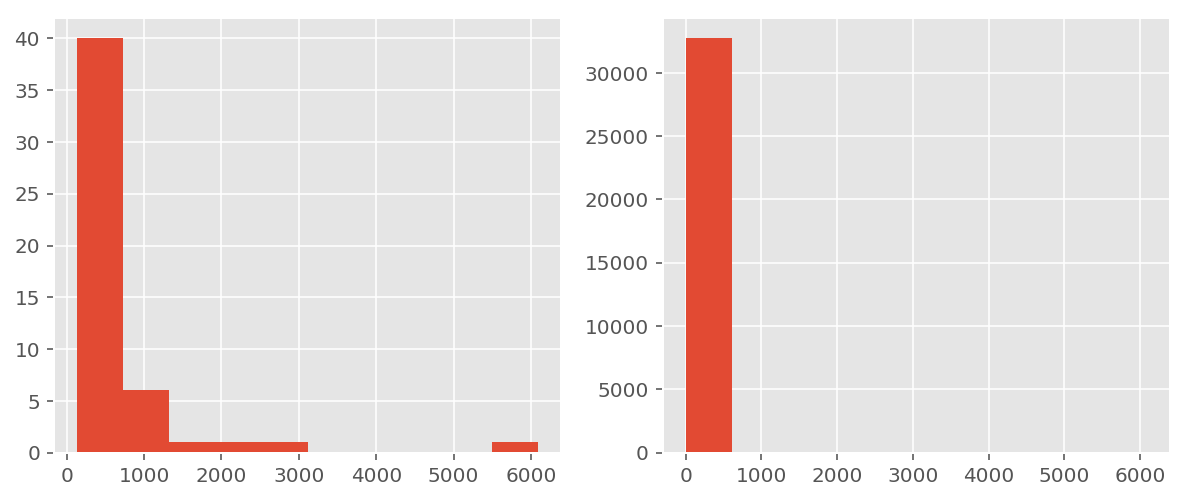

In [33]:
fig, ax = plt.subplots(figsize=(10,4), ncols=2)
ax[0].hist(X_top_50)
ax[1].hist(X_counts)

#### 1.D) Explore n-grams between two and four.
Display the top 75 n-grams with frequencies. Look at each class to see their similarities and differences.

In [37]:
# Look up the appropriate parameters.
# CountVectorizer?
tvec = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(2,4))
X_all = tvec.fit_transform(tweets_df['TEXT'])

X_top_75 = pd.DataFrame(X_all.toarray(), columns=tvec.get_feature_names()).sum().sort_values(ascending=False).head(75)
X_top_75

naturevalley planet                     29.953565
france http                             24.795398
love https                              17.631255
da http                                 16.370170
dsds da                                 16.000000
family love                             15.507448
anti imperialist                        15.101968
junksilver coins                        15.025797
silver junksilver                       15.025797
silver junksilver coins                 15.025797
eiffel_tower france                     14.380727
eiffel_tower france http                14.285346
paris france                            13.798953
love http                               12.973233
wieder da                               12.760805
earth http                              12.748032
schon wieder da                         12.727396
schon wieder                            12.727396
petersvaderlekstjanst yolo              12.044747
hund hunde                              11.908317


#### 1.E) (Optional) Try expanding the list of stop words.
There are definitely some non-words, such as web URLs, that could be removed to help us improve the score. Identify word/tokens that don't add much value to either class. **You should also look at n-grams per language to fine-tune your preprocessing. This has the greatest potential to improve your results without tuning any model parameters.**

Using `nltk.corpus`, we can get a baseline list of stop words. Try to expand it and pass it to our vectorizer.

In [43]:
import nltk

In [67]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = ['http', 'https', 'co'] + stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french') + stopwords.words('swedish') + stopwords.words('german') + stopwords.words('russian') + stopwords.words('portuguese') + stopwords.words('italian')

[nltk_data] Downloading package stopwords to /Users/Noah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
tvec = TfidfVectorizer(strip_accents='unicode', stop_words=stop, ngram_range=(2,4))
X_all = tvec.fit_transform(tweets_df['TEXT'])

X_top_75 = pd.DataFrame(X_all.toarray(), columns=tvec.get_feature_names()).sum().sort_values(ascending=False).head(75)
X_top_75

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'ate', 'avra', 'avro', 'dar', 'eramos', 'estabamos', 'estais', 'estan', 'estao', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'estavamos', 'esteis', 'esten', 'estiveramos', 'estivessemos', 'estuvieramos', 'estuviesemos', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fara', 'faro', 'foramos', 'fossemos', 'fran', 'fueramos', 'fuesemos', 'fumes', 'fur', 'futes', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hao', 'hayais', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'hubieramos', 'hubi

naturevalley planet                           36.965584
family love                                   17.969122
eiffel_tower france                           15.991389
anti imperialist                              15.435633
silver junksilver                             15.351093
silver junksilver coins                       15.351093
coins us                                      15.351093
junksilver coins us                           15.351093
junksilver coins                              15.351093
silver junksilver coins us                    15.351093
paris france                                  15.065579
hund hunde                                    13.004151
petersvaderlekstjanst yolo                    12.200164
us bullion                                    11.505973
coins us bullion                              11.505973
junksilver coins us bullion                   11.505973
peace love                                    11.468987
love sun                                      11

### 2) Set up a train/test split of your data using any method you wish.
Try 70/30 to start.

In [88]:
y, X = tweets_df.pop('LANG'), tweets_df['TEXT']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

### 3) Set up a pipeline to vectorize and use the MultinomialNB classifier.
Use `lowercase`, `strip_accents`, `Pipeline`, and (optionally) your updated `stop_words`. Fit your comment data using the "insult" feature as your response.

Fit your training data set to your pipeline, then score it.

In [92]:
# Here's the code — you can adapt it from here on out.
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words=stop, ngram_range=(2,4))),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
])

pipeline.fit(X_train, y_train)
print(cross_val_score(pipeline, X_train, y_train, cv=5).mean())
print(pipeline.score(X_test, y_test))

# Don't forget to score.

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'ate', 'avra', 'avro', 'dar', 'eramos', 'estabamos', 'estais', 'estan', 'estao', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'estavamos', 'esteis', 'esten', 'estiveramos', 'estivessemos', 'estuvieramos', 'estuviesemos', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fara', 'faro', 'foramos', 'fossemos', 'fran', 'fueramos', 'fuesemos', 'fumes', 'fur', 'futes', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hao', 'hayais', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'hubieramos', 'hubi

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'ate', 'avra', 'avro', 'dar', 'eramos', 'estabamos', 'estais', 'estan', 'estao', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'estavamos', 'esteis', 'esten', 'estiveramos', 'estivessemos', 'estuvieramos', 'estuviesemos', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fara', 'faro', 'foramos', 'fossemos', 'fran', 'fueramos', 'fuesemos', 'fumes', 'fur', 'futes', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hao', 'hayais', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'hubieramos', 'hubi

0.4910411647384558
0.5235565001771165


#### 3.A) Swap out MultinomialNB with BernoulliNB in the pipeline.
How do they compare? Do you have a guess as to why BernoulliNB is so poor?

My answer: because BernoulliNB transforms the tvec into binary 0,1 and removes the counts of the words?

In [93]:
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words=stop, ngram_range=(2,4))),
    ('tfidf', TfidfTransformer()),
    ('cls', BernoulliNB())
])

pipeline.fit(X_train, y_train)
print(cross_val_score(pipeline, X_train, y_train, cv=5).mean())
print(pipeline.score(X_test, y_test))

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'ate', 'avra', 'avro', 'dar', 'eramos', 'estabamos', 'estais', 'estan', 'estao', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'estavamos', 'esteis', 'esten', 'estiveramos', 'estivessemos', 'estuvieramos', 'estuviesemos', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fara', 'faro', 'foramos', 'fossemos', 'fran', 'fueramos', 'fuesemos', 'fumes', 'fur', 'futes', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hao', 'hayais', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'hubieramos', 'hubi

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ar', 'ate', 'avra', 'avro', 'dar', 'eramos', 'estabamos', 'estais', 'estan', 'estao', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'estavamos', 'esteis', 'esten', 'estiveramos', 'estivessemos', 'estuvieramos', 'estuviesemos', 'etaient', 'etais', 'etait', 'etant', 'etante', 'etantes', 'etants', 'ete', 'etee', 'etees', 'etes', 'etiez', 'etions', 'eumes', 'eutes', 'fara', 'faro', 'foramos', 'fossemos', 'fran', 'fueramos', 'fuesemos', 'fumes', 'fur', 'futes', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hao', 'hayais', 'houveramos', 'houverao', 'houveriamos', 'houvessemos', 'hubieramos', 'hubi

0.2774043873566516
0.29543039319872477


#### 3.B) Try logistic regression and random forests in the pipeline.
How do they compare? Recall that logistic regression is discriminative, whereas Naive Bayes is generative. Logistic regression uses optimization to fit a formula that discriminates between the classes, while Naive Bayes essentially just computes aggregate statistics. So, logistic regression should have a longer training time than Naive Bayes — but does it here? (See `%time`.)

**Note**: Logistic regression and random forests both allow you to see feature importance/coefficients. In this case, these coefficients will inform you how strongly each word indicates a language. Optionally, see if you can sort these coefficients by their values to get the strongest and weakest indicator words for languages.

In [165]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words=['http', 'https', 'co', 'love'])),
#    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train, y_train)
print(cross_val_score(pipeline, X_train, y_train, cv=5).mean())
print(pipeline.score(X_test, y_test))

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

0.7754322775701892
0.7899397803754871


#### 3.C) Also, try tweaking the parameters of `CountVectorizer` and `TfidfTranformer`.

Remove TF-IDF. Is this good or bad?
Yes ... slightly better than with TF-IDF
Also.. taking out ngram_range completely is a good idea, and drastically improves the score (50% to 70%)

In [163]:
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words=['http', 'https', 'co'])),
#    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
])

pipeline.fit(X_train, y_train)
print(cross_val_score(pipeline, X_train, y_train, cv=5).mean())
print(pipeline.score(X_test, y_test))

/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


0.7637379983707857
0.7708111937654977


### 4) Check your score.
For which languages does your model work best? Run a classification report for all languages. Plot the area under curve/ROC for particular languages (versus all others) and compare them — do they indicate that some languages perform better? Does our model perform worse while guessing on some languages versus others? 

In [141]:
predictions = pipeline.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          de       0.65      0.71      0.68       334
          en       0.76      0.68      0.72       420
          es       0.37      0.81      0.50       354
          fr       0.76      0.68      0.72       347
          it       0.65      0.57      0.61       269
          pt       0.77      0.57      0.66       309
          ru       0.84      0.63      0.72       223
          sv       0.84      0.67      0.75       202
          tl       0.00      0.00      0.00         1
          uk       0.58      0.19      0.29        58
         und       0.80      0.54      0.64       185
          zh       0.83      0.44      0.57       121

    accuracy                           0.64      2823
   macro avg       0.66      0.54      0.57      2823
weighted avg       0.70      0.64      0.65      2823



/Users/Noah/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Revisiting: ROC/AUC.

Remember how to plot ROC curves for multiple classes using `scikitplot`.

In [103]:
import scikitplot as skplt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [110]:
# Using your pipeline, predict the probabilities of each language.
# Then, plot the ROC curve.
y_pp = pd.DataFrame(pipeline.predict_proba(X_train), columns=pipeline.classes_)
y_pp.head(2)

,de,en,es,fr,it,pt,ru,sv,tl,uk,und,zh
0,0.000312,0.000623,0.044016,0.000034,0.004934,0.942170,0.006612,0.000105,2.428778e-10,1.651980e-04,0.000935,9.352859e-05
1,0.000007,0.000002,0.000008,0.999937,0.000007,0.000006,0.000013,0.000008,2.673514e-11,8.885131e-08,0.000011,5.375803e-07


In [114]:
y_train.head(4)

8329    pt
3320    fr
7420    pt
1712    es
Name: LANG, dtype: object

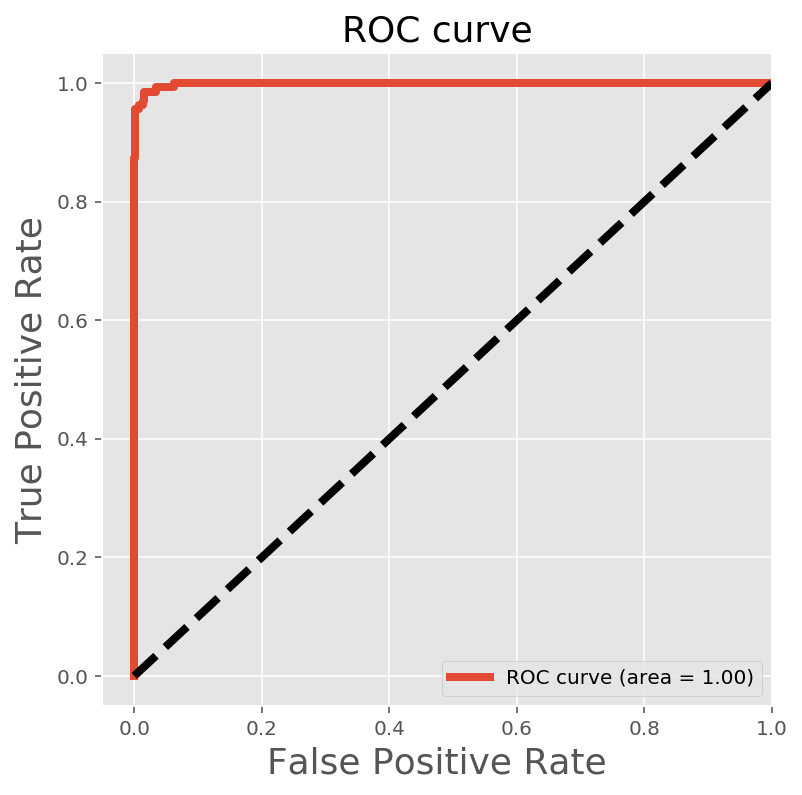

In [126]:
# For one class, find the area under the curve... ROC only works for one class in a multi-class problem.
fpr, tpr, threshold = roc_curve(y_train, y_pp.uk, pos_label='uk')
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 5) Check out your baseline.

What is the chance that you'll randomly guess correctly without any modeling? Assume your input phrase's language has the same chance of appearing as the languages in your training set.

In [139]:
print('Baseline:',y.value_counts(normalize=True).max())
y.value_counts(normalize=True)

Baseline: 0.1487937081517696


en     0.148794
es     0.125306
fr     0.122755
de     0.118185
pt     0.109470
it     0.095228
ru     0.079180
sv     0.071740
und    0.065469
zh     0.043044
uk     0.020406
tl     0.000425
Name: LANG, dtype: float64

### 6) What is your model not getting right?

Check out the incorrectly classified tweets. Are there any noticeable patterns? Can you explain why many of these are incorrectly classified given what you know about how Naive Bayes works? Pay particular attention to the recall metric.  What could be done in the preprocessing steps to improve accuracy?  

- Try to improve your **preprocessing first**.
- Then, try to tweak your **parameters to your model(s)**.

In [164]:
pd.set_option('display.max_colwidth',1000)
check = pd.DataFrame(list(zip(y_test,predictions,X_test)), columns=['y_test', 'pred', 'text'])
false = check[check.y_test != check.pred]
false[false['y_test']=='uk']

,y_test,pred,text
24,uk,ru,Одуванчик просто 🍃🌸 #love #kids #funny #nice #beauty #family #walk #model #look #севастополь http://t.co/b7Sl7y3zSJ
59,uk,pt,Вечеря на двох.... звучить романтично😃😃😃 #yammi\n#sushi #nice #romantic\n#sister #love #loveyoumybaby #dinner #dinne… http://t.co/xY1QGKBxUA
60,uk,ru,#travel #лето #путешествие #summer #romantic #love #sea #summerdays @ Около Севастополя https://t.co/MOYwyGFLz5
74,uk,ru,Найди вторую собаку))) #dog #dogs #харьков http://t.co/qc52LDeWYd
88,uk,en,RT @DoraHoward9: us robotics 56k http://t.co/aehjCzKrMD #us #драйвер драйвер
118,uk,es,Танці біля моря... #family #travel #Ukraine #love https://t.co/I6Rf05UsS8
340,uk,ru,Сеструха.\n\n#tbt #ekaterinburg #vscocam #selfie #family #follow #екатеринбург #сестра #селфи #лето… https://t.co/O90WpvxSH3
370,uk,es,"У Беларусі я не была амаль месяц. І зараз адчуваю, што Радзіма цягне да сябе. Але пакідаць Адэсу ýсе роýна цяжка #love #мора #see #Україна"
431,uk,ru,Via @justfightX \nАртём Гришанов - Я не верю / Remember the #Odessa Massacre May 2 (English subs)\n#Ukraine #Russia #US http://t.co/Ape1rE2Jka
465,uk,de,яковлев ярослав романович. 12.07.2015 🎉 чудо с музыкальными пальчиками 😚 #home #family #nephew… https://t.co/SkxT9fmHru


## Additional Practice

There are two additional data sets in the directory that you can use for more practice:

- **/datasets/tweets_sentiment.csv**: Sentiment analysis.

- **/datasets/insults_train.csv**: [Kaggle data set](https://www.kaggle.com/c/detecting-insults-in-social-commentary). _Warning:_ This content is fairly provocative and contains offensive and insensitive words. However, this type of problem is common in the continuum of comment threads throughout the web.

    - Check out [this blog post](http://webmining.olariu.org/my-first-kaggle-competition-and-how-i-ranked/) by a guy who used support vector machines, a "neural network," and a ton of cleaning to place third in a Kaggle competition using this same data set. Additionally, see [this post](http://peekaboo-vision.blogspot.de/2012/09/recap-of-my-first-kaggle-competition.html) — he took sixth place and found that the best model was a simple logistic regression.

#### Where to next?

If you're interested in this type of problem, a great area to read up on is sentiment analysis. This [Kaggle data set](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) offers an excellent opportunity for more practice.  The following white papers are also great for further exploration in this topic:

- [Fast and accurate sentiment classification using an enhanced Naive Bayes model](http://arxiv.org/pdf/1305.6143.pdf)— *a great overview!*
- [Sarcasm detection](http://www.aclweb.org/anthology/P15-2124)
- [Making computers laugh: Investigations in automatic humor recognition](http://www.aclweb.org/anthology/H05-1067)
- [Modeling sarcasm in Twitter, a novel approach](http://www.aclweb.org/anthology/W14-2609)
- [Narcissism and lie detection](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/107345/zarins.finalthesis.pdf?sequence=1) — *this study's metrics are interesting*